In [1]:
# Use data from Google Drive
from google.colab import drive
drive.mount('/content/drive')
base_data_directory = '/content/drive/MyDrive/lion_no_lion'

Mounted at /content/drive


In [ ]:
# Use data from local directory
import os
base_data_directory = os.path.realpath('../data')

In [15]:
notebook_number = 4
if notebook_number == 1:
    image_dimensions = (128, 128) # height, width
    with_augmentation = False
    batch_size = 16
    model_version = "light"
    model_file = f'{base_data_directory}/model_weights_{notebook_number}_{model_version}_{image_dimensions[0]}_{image_dimensions[1]}.keras'
    history_file = f'{base_data_directory}/model_history_{notebook_number}_{model_version}_{image_dimensions[0]}_{image_dimensions[1]}.pickle'
    lion_directories = [
        f'{base_data_directory}/lion_1',
    ]
    no_lion_directories = [
        f'{base_data_directory}/no_lion_1',
    ]
elif notebook_number == 2:
    image_dimensions = (256, 256) # height, width
    with_augmentation = False
    batch_size = 16
    model_version = "light"
    model_file = f'{base_data_directory}/model_weights_{notebook_number}_{model_version}_{image_dimensions[0]}_{image_dimensions[1]}.keras'
    history_file = f'{base_data_directory}/model_history_{notebook_number}_{model_version}_{image_dimensions[0]}_{image_dimensions[1]}.pickle'
    lion_directories = [
        f'{base_data_directory}/lion_1',
    ]
    no_lion_directories = [
        f'{base_data_directory}/no_lion_1',
    ]
elif notebook_number == 3:
    image_dimensions = (256, 256) # height, width
    with_augmentation = True
    batch_size = 16
    model_version = "light"
    model_file = f'{base_data_directory}/model_weights_{notebook_number}_{model_version}_{image_dimensions[0]}_{image_dimensions[1]}.keras'
    history_file = f'{base_data_directory}/model_history_{notebook_number}_{model_version}_{image_dimensions[0]}_{image_dimensions[1]}.pickle'
    lion_directories = [
        f'{base_data_directory}/lion_1',
    ]
    no_lion_directories = [
        f'{base_data_directory}/no_lion_1',
    ]
elif notebook_number == 4:
    image_dimensions = (128, 128) # height, width
    with_augmentation = False
    batch_size = 16
    model_version = "pre-trained"
    model_file = f'{base_data_directory}/model_weights_{notebook_number}_{model_version}_{image_dimensions[0]}_{image_dimensions[1]}.keras'
    history_file = f'{base_data_directory}/model_history_{notebook_number}_{model_version}_{image_dimensions[0]}_{image_dimensions[1]}.pickle'
    lion_directories = [
        f'{base_data_directory}/lion_1',
    ]
    no_lion_directories = [
        f'{base_data_directory}/no_lion_1',
    ]
elif notebook_number == 5:
    image_dimensions = (128, 128) # height, width
    with_augmentation = False
    batch_size = 16
    model_version = "pre-trained"
    model_file = f'{base_data_directory}/model_weights_{notebook_number}_{model_version}_{image_dimensions[0]}_{image_dimensions[1]}.keras'
    history_file = f'{base_data_directory}/model_history_{notebook_number}_{model_version}_{image_dimensions[0]}_{image_dimensions[1]}.pickle'
    lion_directories = [
        f'{base_data_directory}/lion',
    ]
    no_lion_directories = [
        f'{base_data_directory}/no_lion',
    ]
elif notebook_number == 6:
    image_dimensions = (512, 512) # height, width
    with_augmentation = False
    batch_size = 16
    model_version = "pre-trained"
    model_file = f'{base_data_directory}/model_weights_{notebook_number}_{model_version}_{image_dimensions[0]}_{image_dimensions[1]}.keras'
    history_file = f'{base_data_directory}/model_history_{notebook_number}_{model_version}_{image_dimensions[0]}_{image_dimensions[1]}.pickle'
    lion_directories = [
        f'{base_data_directory}/lion',
        f'{base_data_directory}/cougar',
    ]
    no_lion_directories = [
        f'{base_data_directory}/no_lion',
        f'{base_data_directory}/nocougar',
    ]
else:
    raise Exception(f'Unknown notebook {notebook_number}')

In [3]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  distribution_strategy = tf.distribute.TPUStrategy(tpu)
  print(f'Running on a TPU w/{tpu.num_accelerators()["TPU"]} cores')
except ValueError:
  print("WARNING: Not connected to a TPU runtime; Will try GPU")
  if tf.config.list_physical_devices('GPU'):
    distribution_strategy = tf.distribute.MirroredStrategy()
    print(f'Running on {len(tf.config.list_physical_devices("GPU"))} GPUs')
  else:
    print('WARNING: Not connected to TPU or GPU runtime; Will use CPU context')
    distribution_strategy = tf.distribute.get_strategy()

Tensorflow version 2.15.0
Running on 1 GPUs


In [24]:
def pre_trained_model():
    base_model = tf.keras.applications.Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(*image_dimensions, 3),
    )

    print(f'Number of layers in the base model: {len(base_model.layers)}')
    print(f'shape of output layer: {base_model.layers[-1].output_shape}')

    base_model.trainable = False

    input_layers = []
    if with_augmentation:
        input_layers = [
            tf.keras.layers.RandomFlip(),
            tf.keras.layers.RandomRotation(0.01),
            tf.keras.layers.RandomZoom(0.05),
            tf.keras.layers.RandomBrightness((-0.1, 0.1)),
            tf.keras.layers.RandomContrast(0.1),
            # tf.keras.layers.RandomCrop(200, 200),
            # tf.keras.layers.Rescaling(1./255),
        ]

    model = tf.keras.Sequential([
        *input_layers,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    return model

def light_model():
    inputs = tf.keras.Input(shape=(*image_dimensions, 1))

    # Entry block
    x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
    x = tf.keras.layers.Conv2D(128, 1, strides=2, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 1, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 1, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(1, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = tf.keras.layers.SeparableConv2D(1024, 1, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dropout(0.1)(x)

    outputs = tf.keras.layers.Dense(1, activation=None)(x)
    model = tf.keras.Model(inputs, outputs)

    return model

In [25]:
import os

with distribution_strategy.scope():
    try:
        os.stat(model_file)
        print(f'Loading model from file {model_file}')
        model = tf.keras.models.load_model(model_file)
        print('Loaded model from file')
    except FileNotFoundError:
        if model_version == "pre-trained":
            print('Creating new Xception model')
            model = pre_trained_model()
        elif model_version == "light":
            print('Creating new light model')
            model = light_model()
        else:
            raise Exception(f'unknown model version {model_version}')

        model.build(input_shape=(None, *image_dimensions, 3))

        print(f'Number of layers in the model: {len(model.layers)}')

Creating new Xception model
Number of layers in the base model: 132
shape of output layer: (None, 4, 4, 2048)
Number of layers in the model: 3


In [54]:
with distribution_strategy.scope():
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )
    model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 20863529 (79.59 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [56]:
import pickle

class StoreHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        self.history = {}
        self.number_epochs = 0
        try:
            with open(history_file, 'rb') as f:
                self.history = pickle.load(f)
                keys = list(self.history.keys())
                self.number_epochs = len(self.history[keys[0]])
                print(f'Loaded history of {self.number_epochs} previous epochs')
                last_output = f'Epoch {self.number_epochs}: '
                for key in keys:
                    last_output += f'{key}: {self.history[key][-1]:.4f}'
                    if key != keys[-1]:
                        last_output += ' - '
                print(last_output)
        except FileNotFoundError:
            print('Initialized new history')
            pass

    def on_train_begin(self, logs=None):
        keys = list(self.history.keys())
        if len(keys) == 0:
            self.number_epochs = 0
        else:
            self.number_epochs = len(self.history[keys[0]])
        print(f'Starting new training with {self.number_epochs} previous epochs')

    def on_epoch_end(self, epoch, logs=None):
        if not 'batch_size' in self.history:
            self.history['batch_size'] = []
        self.history['batch_size'].append(batch_size)
        for key in logs:
          if not key in self.history:
              self.history[key] = []
          self.history[key].append(logs[key])
        with open(history_file, 'wb') as f:
            pickle.dump(self.history, f)
            print(f'Epoch {epoch + self.number_epochs + 1} history pickled and saved to file')

full_history = StoreHistory()

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_file,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1,
)

reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # New lr = lr * factor.
    patience=500,
    verbose=1,
    mode='min',
    min_lr=1e-6,  # Lower bound on the learning rate.
)

Loaded history of 9 previous epochs
Epoch 9: batch_size: 16.0000 - loss: 0.0689 - accuracy: 0.9812 - val_loss: 1.1583 - val_accuracy: 0.6250 - lr: 0.0010


In [19]:
import glob
import shutil

lion_images = []
for lion in lion_directories:
    lion_images += glob.glob(os.path.join(lion, '*JPG'))
no_lion_images = []
for no_lion in no_lion_directories:
    no_lion_images += glob.glob(os.path.join(no_lion, '*JPG'))

print(f'Found {len(lion_images)} images tagged as `lion`')
print(f'Found {len(no_lion_images)} images tagges as `no-lion`')
print(f'In total {len(lion_images) + len(no_lion_images)} images')

shutil.rmtree('work', ignore_errors=True)
os.makedirs('work/lion')
os.makedirs('work/no_lion')

print(f'Copying images to working directory {os.path.realpath("work")}')
for image in lion_images:
    shutil.copy(image, 'work/lion')
for image in no_lion_images:
    shutil.copy(image, 'work/no_lion')
print('Copied all images')

Found 100 images tagged as `lion`
Found 100 images tagges as `no-lion`
In total 200 images
Copying images to working directory /content/work
Copied all images


In [32]:
if model_version == 'pre-trained':
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

training_dataset, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'work',
    batch_size=batch_size,
    validation_split=0.2,
    subset='both',
    seed=1042,
    shuffle=True,
    image_size=image_dimensions,
    color_mode=color_mode,
)

Found 200 files belonging to 2 classes.
Using 160 files for training.
Using 40 files for validation.


In [57]:
from datetime import datetime

start_time = datetime.now()
print(start_time)
history = model.fit(
    training_dataset,
    epochs=300,
    validation_data=validation_dataset,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir=f'{base_data_directory}/logs'),
        checkpoint,
        reduce_learning_rate,
        full_history,
    ]
)
end_time = datetime.now()
print(end_time)
print(f'This run took {(end_time - start_time).total_seconds()} seconds')

2024-06-04 14:47:33.315784
Starting new training with 9 previous epochs
Epoch 1/300
10/10 [==============================] - ETA: 0s - loss: 0.0668 - accuracy: 0.9875
Epoch 1: val_loss improved from inf to 1.12296, saving model to /content/drive/MyDrive/lion_no_lion/model_weights_4_pre-trained_128_128.keras
Epoch 10 history pickled and saved to file
10/10 [==============================] - 6s 258ms/step - loss: 0.0668 - accuracy: 0.9875 - val_loss: 1.1230 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 2/300
10/10 [==============================] - ETA: 0s - loss: 0.0632 - accuracy: 0.9875
Epoch 2: val_loss did not improve from 1.12296
Epoch 11 history pickled and saved to file
10/10 [==============================] - 4s 164ms/step - loss: 0.0632 - accuracy: 0.9875 - val_loss: 1.1624 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 3/300
10/10 [==============================] - ETA: 0s - loss: 0.0588 - accuracy: 0.9937
Epoch 3: val_loss did not improve from 1.12296
Epoch 12 history pickled and save

KeyboardInterrupt: 

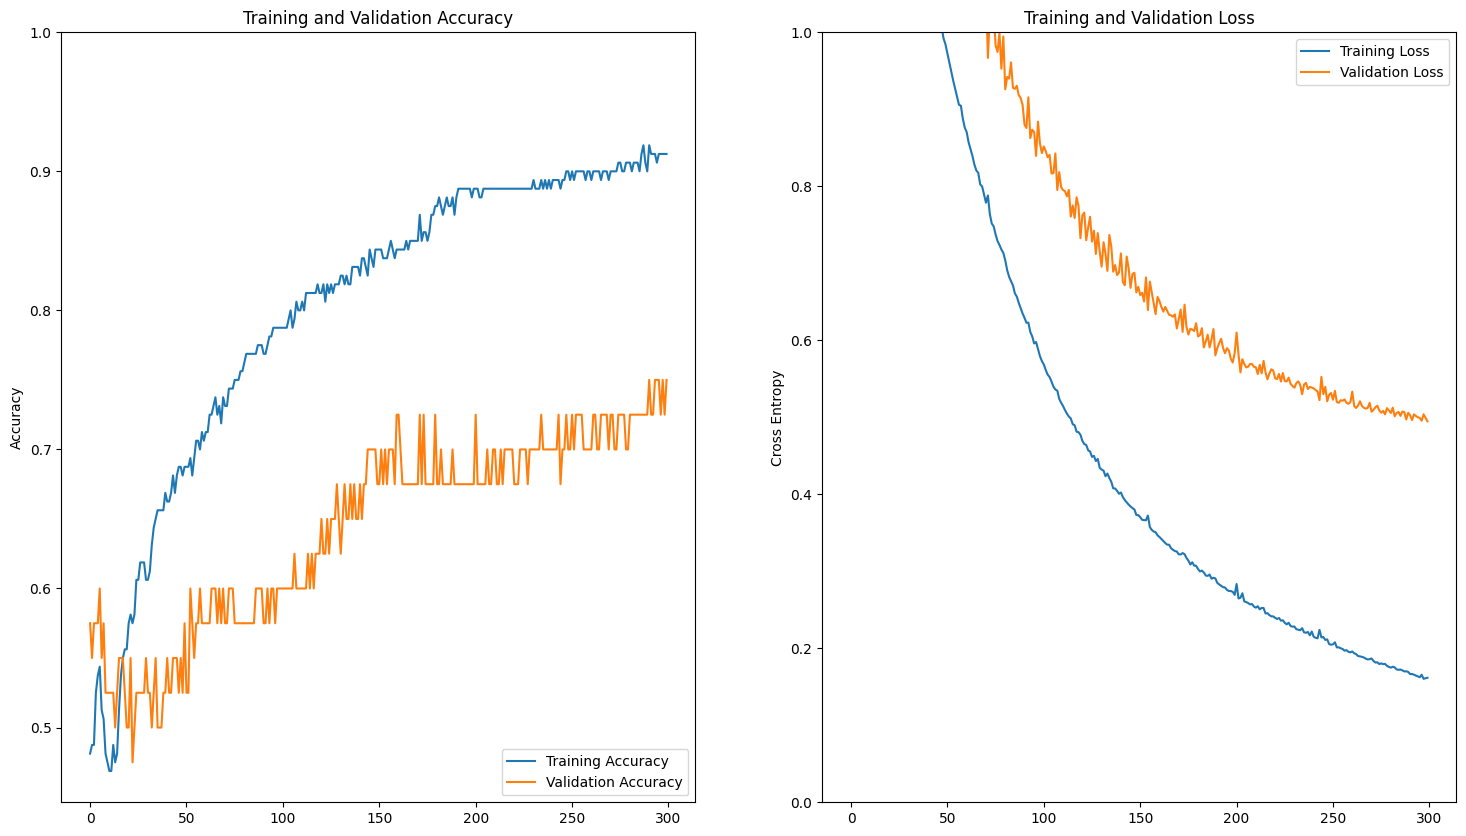

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))
plt.subplot(1, 2, 1)
plt.plot(full_history.history['accuracy'], label='Training Accuracy')
plt.plot(full_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(full_history.history['loss'], label='Training Loss')
plt.plot(full_history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(iter(validation_dataset))

# Predict the labels for the images
predictions = model.predict(images)

# Plot the images and their predicted labels
plt.figure(figsize=(18, 18))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title(f"Predicted: {predictions[i][0]:.2f} ({'lion' if predictions[i][0] < 0.5 else 'no lion'}), Actual: {labels[i]} ({'lion' if labels[i] == 0 else 'no lion'})")
  plt.axis('off')

plt.show()

NameError: name 'validation_dataset' is not defined

1/1 [==============================] - 0s 465ms/step


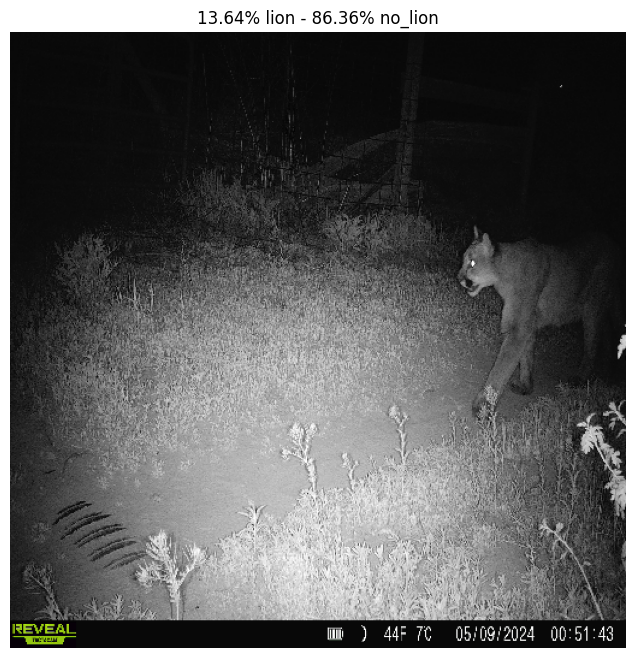

1/1 [==============================] - 0s 473ms/step


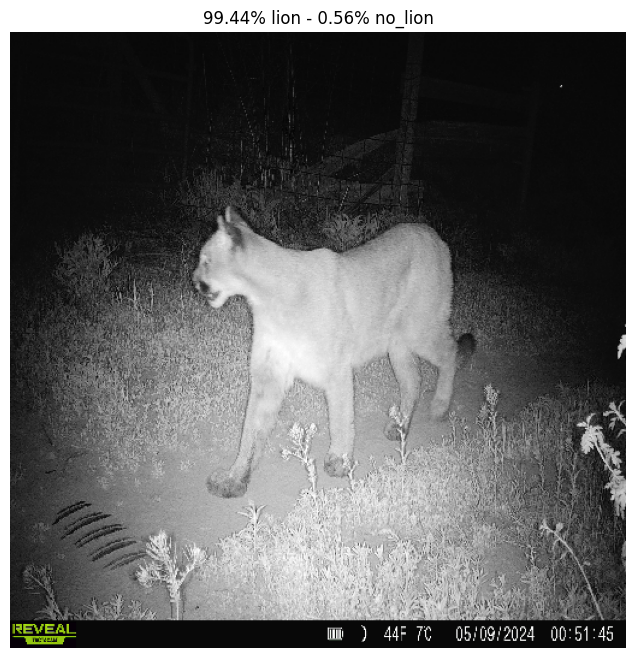

1/1 [==============================] - 0s 476ms/step


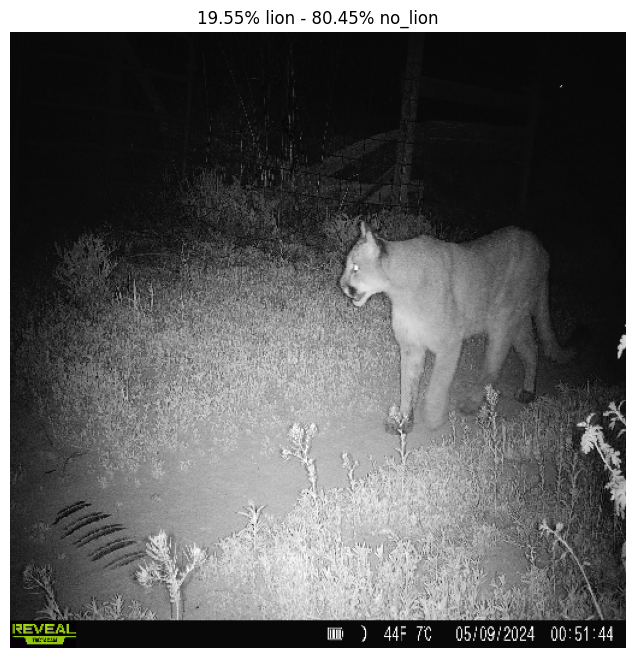

1/1 [==============================] - 0s 442ms/step


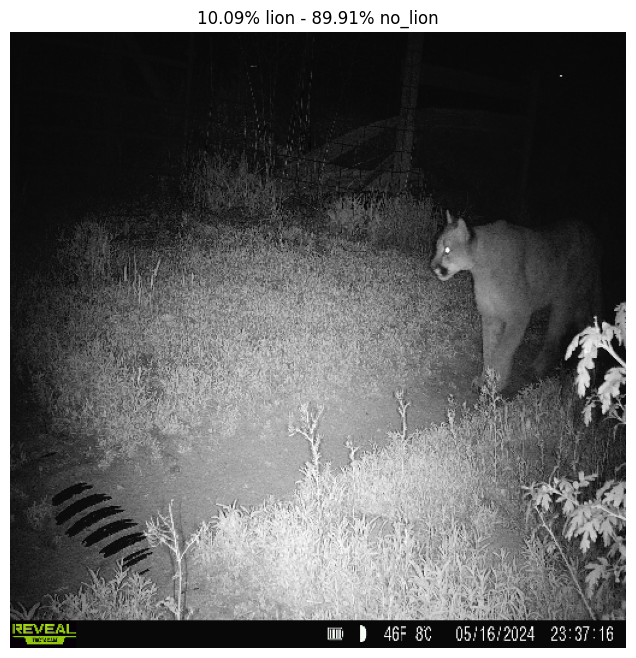

1/1 [==============================] - 0s 481ms/step


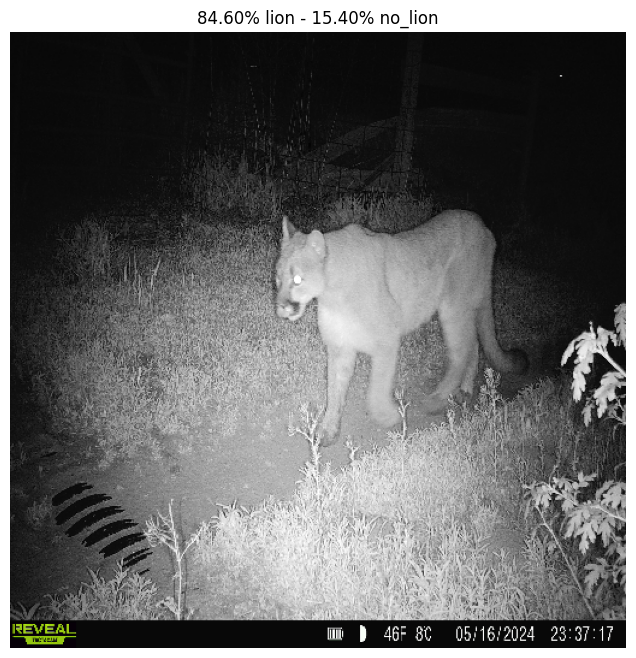

1/1 [==============================] - 0s 437ms/step


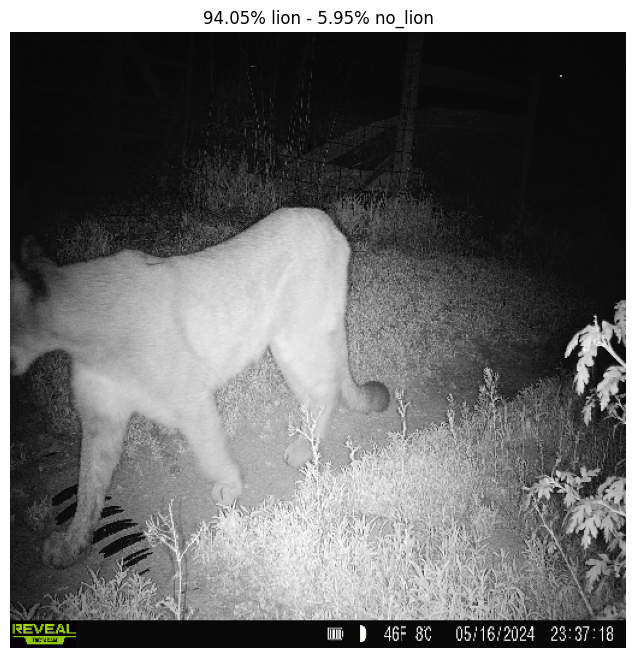

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt

# classification_directory = '/content/drive/MyDrive/lion_no_lion/stable/angle 1'
classification_directory = '/content/drive/MyDrive/lion_no_lion/stable/angle 2/Lion'
# classification_directory = '/content/drive/MyDrive/lion_no_lion/cougar'
# classification_directory = '/content/drive/MyDrive/lion_no_lion/lion'
# classification_directory = '/content/drive/MyDrive/lion_no_lion/nocougar'
classification_image_files = glob.glob(os.path.join(classification_directory,"*JPG"))
classifications = []
for image_file in classification_image_files:
    image_data = tf.keras.utils.load_img(image_file, target_size=image_dimensions)
    image_data = tf.keras.utils.img_to_array(image_data)
    prediction = model.predict(np.expand_dims(image_data, 0))
    classifications.append({})
    classifications[-1]['path'] = image_file
    classifications[-1]['image'] = image_data
    classifications[-1]['prediction'] = prediction[0][0]

    plt.figure(figsize=(8, 8))
    plt.imshow(np.array(classifications[-1]['image'].astype("uint8")))
    plt.title(f'{(1-classifications[-1]["prediction"])*100:.2f}% lion - {classifications[-1]["prediction"]*100:.2f}% no_lion')
    plt.axis('off')
    plt.show()